# Questions 
* What are the graphs that show val_accuracy
* What's happening with a .compile


# Objectives
YWBAT
* build neural networks and tune hyperparams in Keras
* evaluate NNs


# Agenda
* I will walk through a model and build it 
* Your group will build models to find the best model

# What's the first step for NLP?
* Acquire the data
* Look at and format it for the model
    * format = vectorization
    * what are some types of vectorizations for NLP
        * Bag Of Words - each word is a column and each row gets a word count for each column
        * TFIDF - each word is a column and each row gets a tfidf score for each word
        * TF - 
        * IDF - 
        * Word Embeddings - contextual vectors

In [38]:
import pandas as pd
import numpy as np
import string
import nltk

from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import fetch_20newsgroups


import keras
from keras import optimizers
from keras.layers import Dense

from gensim.models import Word2Vec


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("data/nlp_data_train.csv")
df_test = pd.read_csv("data/nlp_data_test.csv")
display(df_train.head(2))
display(df_test.head(2))
df_train.shape, df_test.shape

,article,label,processed_article,cleaned_article_string
0,Note: These trial updates are summarized from ...,4,"['note', 'trial', 'updates', 'summarized', 're...",note trial updates summarized reports idaho st...
1,NaN,3,[],NaN


,article,label,processed_article,cleaned_article_string
0,[ ... ],4,[],NaN
1,"\nonce upon a time, that's exactly what they w...",4,"['upon', 'time', 'exactly', 'would', 'done', '...",upon time exactly would done everyone could go...


((2814, 4), (1873, 4))

In [3]:
bow = CountVectorizer(max_features=5000)

In [4]:
bow_train = bow.fit_transform(df_train["processed_article"])
bow_test = bow.transform(df_test["processed_article"])

In [5]:
bow_train.shape, bow_test.shape

((2814, 5000), (1873, 5000))

In [6]:
len(bow.vocabulary_)

5000

In [7]:
# first one hot encode our target
encoder = OneHotEncoder()

In [8]:
y_train_enc = encoder.fit_transform(df_train["label"].values.reshape(-1, 1))
y_test_enc = encoder.fit_transform(df_test["label"].values.reshape(-1, 1))

In [9]:
y_train_enc.shape, y_test_enc.shape

((2814, 5), (1873, 5))

In [10]:
df_train['label'][:5]

0    4
1    3
2    1
3    4
4    0
Name: label, dtype: int64

In [11]:
y_train_enc.todense()[:5]

matrix([[0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]])

# Let's build a NN to best predict the outcome

In [12]:
model = keras.Sequential()

W0408 13:29:59.530045 140735865734016 deprecation_wrapper.py:119] From /Users/rafael/anaconda3/envs/flatiron-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [13]:
model.add(Dense(units=5000, use_bias=False, activation='relu', input_dim=5000))
model.add(Dense(units=5, activation='softmax'))

W0408 13:30:16.317456 140735865734016 deprecation_wrapper.py:119] From /Users/rafael/anaconda3/envs/flatiron-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0408 13:30:16.321883 140735865734016 deprecation_wrapper.py:119] From /Users/rafael/anaconda3/envs/flatiron-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5000)              25000000  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 25005     
Total params: 25,025,005
Trainable params: 25,025,005
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_optimizer = optimizers.Adam(lr=0.001)

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=model_optimizer)

In [21]:
history = model.fit(bow_train, y_train_enc, epochs=10, batch_size=200, verbose=1)

Epoch 1/10
2814/2814 [==============================] - 8s 3ms/step - loss: 0.6353
Epoch 2/10
2814/2814 [==============================] - 7s 2ms/step - loss: 0.1622
Epoch 3/10
2814/2814 [==============================] - 7s 2ms/step - loss: 0.1022
Epoch 4/10
2814/2814 [==============================] - 7s 2ms/step - loss: 0.0753
Epoch 5/10
2814/2814 [==============================] - 6s 2ms/step - loss: 0.0624
Epoch 6/10
2814/2814 [==============================] - 7s 2ms/step - loss: 0.0546
Epoch 7/10
2814/2814 [==============================] - 7s 2ms/step - loss: 0.0498
Epoch 8/10
2814/2814 [==============================] - 7s 2ms/step - loss: 0.0465
Epoch 9/10
2814/2814 [==============================] - 7s 2ms/step - loss: 0.0440
Epoch 10/10
2814/2814 [==============================] - 7s 2ms/step - loss: 0.0422


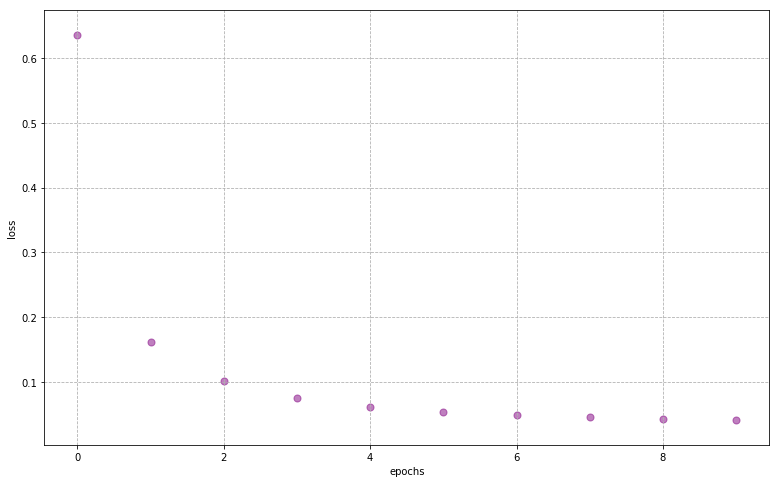

In [22]:
def plot_history(history, figsize=(13, 8), color='purple', s=50, alpha=0.5):
    plt.figure(figsize=figsize)
    plt.grid(zorder=0, linestyle='--')
    plt.scatter(history.epoch, history.history["loss"], c=color, s=s, alpha=alpha)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
    
plot_history(history)

In [29]:
y_preds = model.predict(bow_test)
y_preds[:3]

array([[2.0113520e-01, 1.9291784e-01, 2.1126461e-01, 1.9568740e-01,
        1.9899490e-01],
       [4.9218485e-01, 8.5146412e-06, 5.7058659e-04, 1.1563552e-02,
        4.9567258e-01],
       [2.7016386e-01, 4.1172105e-01, 6.7370539e-03, 1.9455597e-01,
        1.1682206e-01]], dtype=float32)

In [33]:
y_pred_labels = np.argmax(y_preds, axis=1)

In [36]:
report = classification_report(df_test['label'], y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       319
           1       0.94      0.87      0.90       395
           2       0.84      0.93      0.88       399
           3       0.80      0.79      0.80       396
           4       0.79      0.76      0.77       364

    accuracy                           0.83      1873
   macro avg       0.83      0.83      0.83      1873
weighted avg       0.83      0.83      0.83      1873



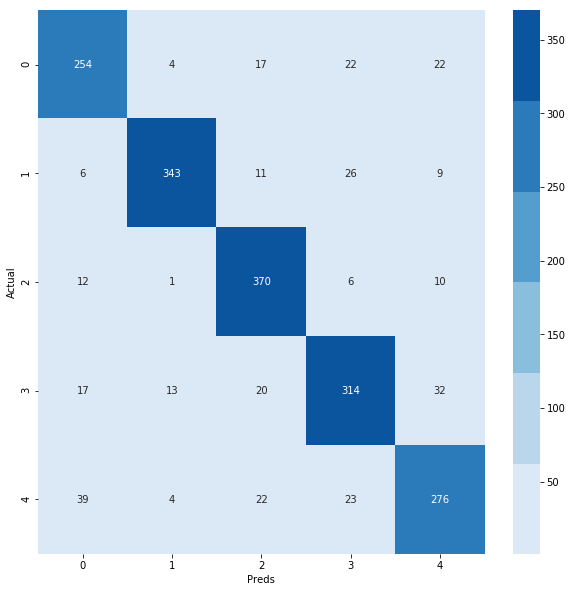

In [41]:
cm = confusion_matrix(df_test['label'], y_pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap=sns.color_palette('Blues'), fmt='0.3g')
plt.xlabel("Preds")
plt.ylabel("Actual")
plt.show()